In [203]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import feather
from random import randint

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns

# sklearn model imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, roc_curve, classification_report, confusion_matrix, f1_score, roc_auc_score, jaccard_similarity_score,pairwise_distances
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.decomposition import LatentDirichletAllocation 

#Text models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

#local imports
from xm_functions import *


InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option('display.float_format', lambda x: '%.3f' % x) #display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

### Quickly import our feather clean dataset

In [204]:
df = pd.read_feather('df_transformed_stackoverflow_posts.feather')

In [205]:
df_tags_to_replace= pd.read_csv('tags_to_replace.csv').set_index('1')
final_tags_list =  set(df_tags_to_replace.index)


def replace_tags(x):
    tags = x.split(' ')
    replace_tags = set(tags) & final_tags_list
    if 'null' in tags:
        tags[tags.index('null')]=''
    for tag in replace_tags:
        tags[tags.index(tag)] = df_tags_to_replace.loc[tag].values[0]
    return np_str(tags)
df['new_tags'] = df['tags'].apply(replace_tags)
print('Secondary tags replaced')

Secondary tags replaced


In [206]:
df.head(15)
df.shape

,title,body,tags,old_tags,body_LancasterStemmer,title_LancasterStemmer,old_body_LancasterStemmer,old_title_LancasterStemmer,new_tags
0,certain situations require use bitwise operato...,day trying code small c++ programming using sd...,c++,c++ event-handling sdl bitwise-operators boole...,day try cod smal c++ program us sdl libr ran s...,certain situ requir us bitw op instead log eq op,day try cod smal c++ program us sdl multimed l...,certain situ requir us bitw op instead log eq op,c++
1,create channel youtube upload videos possible ...,using https github com youtube yt direct lite ...,ios objective-c,ios objective-c video youtube-data-api youtube...,us https github com youtub direct lit io sampl...,cre channel youtub upload video poss cre chann...,us https github com youtub yt direct lit io sa...,cre channel youtub upload video poss cre chann...,ios objective-c
2,design decision boolean containsall collection...,boolean containsall collection c method collec...,java generics,java generics wildcard,bool collect c method collect framework allow ...,design decid bool collect c vs bool addal coll...,bool containsal collect c method collect frame...,design decid bool containsal collect c vs bool...,java generics
3,type universe cannot resolve assembly system c...,developing uwp app via vs win app running perf...,,win-universal-app,develop ap via vs win ap run perfect today sta...,typ univers cannot resolv assembl system confi...,develop uwp ap via vs win ap run perfect today...,typ univers cannot resolv assembl system confi...,
4,java specification implementation gets imports...,difficultly understanding various vendors impl...,java,java specifications,difficult understand vary vend impl spec examp...,jav spec impl get import interfac impl,difficult understand vary vend impl spec examp...,jav spec impl get import interfac impl,java
5,ora connect failed target host object exist er...,believe ask question cannot life connect oracl...,c# sql oracle,c# sql oracle,believ ask quest cannot lif connect orac g dat...,or connect fail target host object ex er syste...,believ ask quest cannot lif connect orac g dat...,or connect fail target host object ex er syste...,c# sql sql
6,ios development launch screen show run project...,know first time came accross issue note set la...,ios objective-c iphone,ios objective-c iphone,know first tim cam issu not set launch screen,io develop launch screen show run project ipho...,know first tim cam accross issu not set launch...,io develop launch screen show run project ipho...,ios objective-c iphone
7,formatting decimal value tostring commas thous...,many decimals rounded differently decimal quan...,c# string,c# string formatting decimal number-formatting,many decim round diff decim quant decim round ...,format decim valu tost comma thousand sep amou...,many decim round diff decim quant decim round ...,format decim valu tost comma thousand sep amou...,c# string
8,best use oop principles deal case + matching c...,class takes lines text uses different criteria...,php oop,php oop,class tak lin text us diff criter individ preg...,best us oop principl deal cas + match criter n...,class tak lin text us diff criter individ preg...,best us oop principl deal cas + match criter n...,php oop
9,ie css bug maintain position absolute dynamic ...,page column content div somewhat like div id c...,css,css internet-explorer-6 internet-explorer-7,pag column cont div somewh lik div id contain ...,ie css bug maintain posit absolv dynam javascr...,pag column cont div somewh lik div id contain ...,ie css bug maintain posit absolv dynam javascr...,css


(43254, 9)

## Apply Pre transform to our posts, titles and tags

In [207]:
pre_transform = '_LancasterStemmer'
posts = df.loc[0:, 'body'+pre_transform]
posts_titles= df.loc[0:, 'title'+pre_transform]
posts_tags= df.loc[0:, 'new_tags']
posts_ids = df.index
nb_posts= posts_ids.shape[0]

### CountVectorizer of tags

In [208]:
# binary ensures repeated tags are counted once
countvector = CountVectorizer( binary =True, token_pattern ='[^\s]+')

# Apply fit_transform 
csrm_y = countvector.fit_transform(posts_tags)

tags_features = pd.Series([ word for word in countvector.get_feature_names()])
df_y= pd.DataFrame(csrm_y.toarray(),index=posts_ids, columns=tags_features.values)

nb_tags_distinct=df_y.shape[1]
print(nb_tags_distinct,'distinct tags remaining. (', nb_posts,'posts )')

95 distinct tags remaining. ( 43254 posts )


### Tfidf of words in posts' body and title

In [105]:
# Create a TfidfVectorizer
min_occurences = round(nb_posts/1000)
vectorizer  = TfidfVectorizer( token_pattern ='[^\s]+')

# Apply fit_transform 
# Add post_titles *2 to add weight to titles and posts' body 
csrm_x = vectorizer.fit_transform(posts_titles+' '+posts_titles+' '+posts)

word_features = pd.Series([ word for word in vectorizer.get_feature_names()])
df_x = pd.DataFrame(csrm_x.toarray(),index=posts_ids, columns=word_features.values)

nb_words_distinct=df_x.shape[1]
print(nb_words_distinct,'distinct words remaining from title and body'+pre_transform ,'(', nb_posts,'posts )')
df_x.head(1)

4708 distinct words remaining from title and body_LancasterStemmer ( 43254 posts )


,#,##,###,#content,#define,#endif,#f,#ff,#fff,#ffffff,#id,#if,#ifdef,#ifndef,#import,#include,#nav,#pragma,#temp,#this,+,++,++i,+i,+id,...,year,yellow,yesterday,yet,yi,yield,yml,york,yosemit,youtub,yum,yy,yyy,yyyy,z,za,zend,zero,zip,zipcod,zon,zoom,zygoteinit,zz,zzz
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Supervised multi labels models


In [212]:
# First split to put aside test_set and avoid biais on future scoring
r_state = 42
X_train, X_test, y_train, y_test = train_test_split(csrm_x, csrm_y, test_size = 0.25, random_state=r_state )

In [213]:
del X_test, y_test

In [222]:
# New split of the train set, into a smaller train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25)

### Selecting most important words (home made)

We start by classifying every tag with LinearSVC and save coefs of every feature in a table <br> Expected errors due to lack of data on some tags

In [224]:

classifier = LinearSVC(penalty = 'l2',  dual = False)
df_coefs = pd.DataFrame(index = tags_features.values ,columns=np.insert( df_x.columns,0,'score', axis=0))

for target_i in range(len(tags_features.values)):
    y_train_i = y_train[:,target_i].toarray().flatten()
    y_test_i   = y_test[:,target_i].toarray().flatten()

    silent = classifier.fit(X_train, y_train_i)
    predictions = classifier.predict(X_test)
    df_coefs.iloc[target_i,1:] =classifier.coef_

    # count number of predicted tags
    unique, counts = np.unique(predictions, return_counts=True)
    #If at least one tag predicted
    if unique[-1]==1 :#dict(zip(unique, counts))[1] > 0:
        df_coefs.iloc[target_i,0] =  f1_score(y_test_i, predictions, labels =[1])
    else:
        df_coefs.iloc[target_i,0] = 0
        
df_coefs.shape
df_coefs.head(3)



(95, 4709)

,score,#,##,###,#content,#define,#endif,#f,#ff,#fff,#ffffff,#id,#if,#ifdef,#ifndef,#import,#include,#nav,#pragma,#temp,#this,+,++,++i,+i,...,year,yellow,yesterday,yet,yi,yield,yml,york,yosemit,youtub,yum,yy,yyy,yyyy,z,za,zend,zero,zip,zipcod,zon,zoom,zygoteinit,zz,zzz
.net,0.219,0.453,-0.152,-0.227,-0.000,-0.208,0.096,-0.011,-0.025,-0.012,-0.002,0.608,0.494,-0.040,-0.019,-0.078,-0.411,-0.000,0.110,-0.017,-0.000,-0.263,-0.204,-0.114,-0.002,...,0.156,1.369,-0.530,0.136,-0.127,-0.230,-0.032,0.000,-0.009,-0.132,-0.000,-0.192,-0.409,-0.288,0.029,0.205,-0.311,0.138,0.691,-0.180,-0.227,0.086,-0.000,-0.231,-0.030
algorithm,0.454,-0.471,0.291,-0.000,0.000,0.333,-0.130,0.000,-0.099,-0.059,-0.044,-0.000,0.315,-0.101,-0.035,-0.065,-0.188,-0.000,-0.004,-0.000,0.000,0.162,-0.289,-0.141,-0.000,...,0.135,-0.095,-0.158,0.298,-0.000,0.776,-0.024,-0.004,0.000,-0.138,-0.000,-0.364,-0.054,-0.024,0.745,-0.367,-0.030,0.175,0.762,-0.063,-0.097,-0.495,-0.000,-0.135,-0.000
amazon-web-services,0.471,0.395,-0.006,-0.000,-0.000,-0.003,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.067,0.000,-0.000,-0.000,-0.012,0.089,-0.022,-0.008,0.000,...,-0.068,-0.002,-0.027,-0.079,-0.076,-0.011,0.433,-0.000,-0.012,-0.025,0.062,0.000,-0.029,-0.005,-0.051,-0.000,0.063,0.264,-0.023,0.000,-0.207,0.000,0.000,0.000,-0.030


Now we evaluate total importance of each feature <br> Selecting top 50 feature by absolute coef for each tag <br> Sum them together to get total coef. <br> And weigh with the score, as a low score means the tag coeff doesn't matter much <br>
Total_feature_importance = SUM( tags_coeff * tags_score )

In [225]:

df_importance_score = pd.DataFrame(0, index = df_coefs.columns, columns = ['score', 'occ_count'] )

for i in df_coefs.index :
    top_ = df_coefs.loc[i, :].abs().sort_values(0)[-50:]*df_coefs.loc[i, 'score']
    df_importance_score.loc[top_.index, 'score'] += top_.values
    df_importance_score.loc[top_.index, 'occ_count'] += 1


df_importance_score.drop('score', axis =0, inplace = True)
df_importance_score['mean_score'] = df_importance_score['score']/ np.sqrt(df_importance_score['occ_count']+0.001)

nb_features = df_importance_score.shape[0]

print(df_importance_score[df_importance_score.score>0.001].shape[0],'features with postitive score out of', nb_features)
### We keep only top 20 %

ten_percent_score = df_importance_score.mean_score.quantile(0.8)
print('We ll remove 80% of features : with an importance score less than ', ten_percent_score )

best_features = df_importance_score[df_importance_score.mean_score>ten_percent_score].index
best_words = pd.DataFrame(best_features)[0].values
print(best_words.shape[0], 'words remaining')
print("Top Most important words")
df_importance_score.sort_values('mean_score', ascending=False).head(5)

2465 features with postitive score out of 4708
We ll remove 80% of features : with an importance score less than  0.6967925106830248
942 words remaining
Top Most important words


,score,occ_count,mean_score
python,17.407,12,5.025
php,13.486,8,4.768
c#,14.087,9,4.695
android,14.447,10,4.568
c++,8.303,4,4.151


In [226]:

df_importance_score.sort_values('mean_score', ascending=False).head(5)

,score,occ_count,mean_score
python,17.407,12,5.025
php,13.486,8,4.768
c#,14.087,9,4.695
android,14.447,10,4.568
c++,8.303,4,4.151


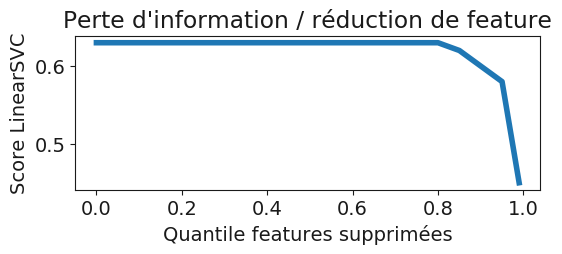

In [230]:
fig_size(6,2 ,14)
#Tableau de score précalculés et reporté ici
final_score_per_reduction = pd.DataFrame([[0.63,0.63, 0.62, 0.60, 0.58, 0.45], [0, 0.8, 0.85, 0.90, 0.95, 0.99]], index=['Score', 'Quantile']).T
plt.rcParams['lines.linewidth'] = 4
myplt = sns.lineplot('Quantile', 'Score', data = final_score_per_reduction )
legend(myplt, 'Perte d\'information / réduction de feature', 'Quantile features supprimées', 'Score LinearSVC')

In [231]:
df_display = df_importance_score[df_importance_score.score>ten_percent_score].copy()
df_display.columns =['Score total', 'NB tags influencés', 'Score moyen' ]
df_display[['NB tags influencés', 'Score moyen']].sort_values('Score moyen', ascending=False).head(10)

,NB tags influencés,Score moyen
python,12,5.025
php,8,4.768
c#,9,4.695
android,10,4.568
c++,4,4.151
jquery,3,4.050
laravel,1,3.943
django,1,3.932
jav,10,3.772
spring,2,3.652


## Exporting most important words' list

In [232]:
pd.DataFrame(best_words, columns= ['word']).to_csv('important_words_l2'+pre_transform+'.csv', index=False)
pd.DataFrame(best_words, columns= ['word']).to_csv('OCR_Project6_StackOverFlow/API/ressources/important_words_l2'+pre_transform+'.csv', index=False)
print('export done')

export done
